### Fera formidável 4.3 Derrube pra fora


Alunos: José Victor da Silva Izidório

#### Enunciado

Objetivo: implemente o regularizador dropout na rede neural feita em Python puro.

Comentário: algumas tarefas vão apresentar palavras e conceitos que ainda não
vimos em sala. Parte do desafio é justamente se informar sobre estes conceitos.






#### 🧠 Dropout em Redes Neurais com Python Puro

Neste notebook, vamos explorar a técnica de **dropout**, usada como regularizador em redes neurais para evitar *overfitting*. A implementação foi feita manualmente em Python puro, alterando a classe `Camada`.

Para esse  código, utilizarei como base o mesmo dataset da Fera 4.1, pois achei que seria interessante verificar como o dropout atuaria em um problema de classificação.


#### O que é Dropout?

**Dropout** é uma técnica de regularização usada em redes neurais artificiais para reduzir o risco de *overfitting*.

Durante o treinamento, uma fração dos neurônios é **aleatoriamente "desligada"** a cada passo, o que força a rede a aprender representações mais distribuídas e resilientes.

Durante a inferência (teste), todos os neurônios são utilizados normalmente, mas suas ativações foram devidamente escalonadas durante o treino.

**Benefícios do Dropout:**
- ✅ Reduz overfitting
- ✅ Estimula a robustez
- ✅ Impede que a rede dependa de neurônios específicos


In [41]:
import random
import math
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from Fera_4_3_classes import Valor, Neuronio, Camada, MLP, cross_entropy

In [42]:
df = pd.read_csv("heart.csv")
df

,Age,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,HeartDisease
0,40,ATA,140,289,Normal,172,0
1,49,NAP,160,180,Normal,156,1
2,37,ATA,130,283,ST,98,0
3,48,ASY,138,214,Normal,108,1
4,54,NAP,150,195,Normal,122,0
...,...,...,...,...,...,...,...
913,45,TA,110,264,Normal,132,1
914,68,ASY,144,193,Normal,141,1
915,57,ASY,130,131,Normal,115,1
916,57,ATA,130,236,LVH,174,1


Usando o one hot encoder nas colunas `ChestPainType` e `RestingECG`

In [43]:
ChestPainType = df["ChestPainType"]

ChestPainType = ChestPainType.values.reshape(-1, 1)
 
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(ChestPainType)
 
ChestPainType_onehot = encoder.transform(ChestPainType)

column_names = encoder.get_feature_names_out(["ChestPainType"])
df_onehot_pain = pd.DataFrame(ChestPainType_onehot, columns=column_names)

df = df.drop(columns=["ChestPainType"])

df = pd.concat([df, df_onehot_pain], axis=1)

In [44]:
RestingECG = df["RestingECG"]

RestingECG = RestingECG.values.reshape(-1, 1)
 
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(RestingECG)
 
RestingECG_onehot = encoder.transform(RestingECG)

column_names = encoder.get_feature_names_out(["RestingECG"])
df_onehot_resting = pd.DataFrame(RestingECG_onehot, columns=column_names)

df = df.drop(columns=["RestingECG"])

df = pd.concat([df, df_onehot_resting], axis=1)

In [45]:
df

,Age,RestingBP,Cholesterol,MaxHR,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
0,40,140,289,172,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,49,160,180,156,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,130,283,98,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,48,138,214,108,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,54,150,195,122,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,132,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0
914,68,144,193,141,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
915,57,130,131,115,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
916,57,130,236,174,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [46]:
entradas = df.drop(columns=["HeartDisease"]).values
saidas = df["HeartDisease"].values.reshape(-1, 1)

In [47]:
TAMANHO_TESTE_E_VALIDACAO = 0.1 

# Alocando 10% dos dados para teste
entradas_temp, entradas_teste, saidas_temp, saidas_teste = train_test_split(
    entradas, saidas, test_size=TAMANHO_TESTE_E_VALIDACAO, random_state=36)

# Alocando 10% dos dados para validação
entradas_treino, entradas_val, saidas_treino, saidas_val = train_test_split(
    entradas_temp, saidas_temp, test_size=TAMANHO_TESTE_E_VALIDACAO, random_state=36)

Normalizando os dados:

In [48]:
normalizador = MinMaxScaler()
entradas_treino = normalizador.fit_transform(entradas_treino)
entradas_val = normalizador.transform(entradas_val)
entradas_teste = normalizador.transform(entradas_teste)

Para teste, iremos rodar duas redes neurais simultâneas, uma com e outra sem dropout. Para copiar os pesos iniciais, utilizarei o deepcopy.

In [49]:
from copy import deepcopy

epocas = 200
taxa_aprendizado = 0.1
num_features_entrada = entradas_treino.shape[1]  # Número real de features


historico = {
    "com_dropout": {"treino": [], "val": []},
    "sem_dropout": {"treino": [], "val": []}
}


# Configuração da arquitetura
config_com_dropout = [
    (3, 0.1),  # Camada oculta 1
    (2, 0.1),  # Camada oculta 2
    (1, 0.0)   # Saída
]

config_sem_dropout = [
    (3, 0.0),  # Dropout desativado
    (2, 0.0),
    (1, 0.0)
]

# Instanciando os dois modelos
modelo_com_dropout = MLP(num_entradas=num_features_entrada, tamanhos_camadas_config=config_com_dropout)
modelo_sem_dropout = deepcopy(modelo_com_dropout)  # Clona pesos iniciais

# Treinamento paralelo
for epoca in range(epocas):
    perdas = {"dropout": 0.0, "sem_dropout": 0.0}
    perdas_treino = {"dropout": 0.0, "sem_dropout": 0.0}

    for modelo, nome, use_dropout in [
        (modelo_com_dropout, "dropout", True),
        (modelo_sem_dropout, "sem_dropout", False)
    ]:
        # --- TREINAMENTO ---
        saidas_preditas_treino = []
        for x, y in zip(entradas_treino, saidas_treino):
            entrada_valores = [Valor(v) for v in x]
            pred = modelo(entrada_valores, training=use_dropout)
            saidas_preditas_treino.append(pred)

        perda_treino = cross_entropy(saidas_treino.flatten().tolist(), saidas_preditas_treino)
        for p in modelo.params():
            p.grad = 0.0
        perda_treino.backward()

        for p in modelo.params():
            p.data -= taxa_aprendizado * p.grad

        perdas_treino[nome] = perda_treino.data

        # --- VALIDAÇÃO ---
        saidas_preditas_val = []
        for x in entradas_val:
            entrada_valores = [Valor(v) for v in x]
            pred = modelo(entrada_valores, training=False)
            saidas_preditas_val.append(pred)

        perda_val = cross_entropy(saidas_val.flatten().tolist(), saidas_preditas_val)
        perdas[nome] = perda_val.data

    # Armazenar as perdas por época no histórico
    historico["com_dropout"]["treino"].append(perdas_treino["dropout"])
    historico["com_dropout"]["val"].append(perdas["dropout"])
    historico["sem_dropout"]["treino"].append(perdas_treino["sem_dropout"])
    historico["sem_dropout"]["val"].append(perdas["sem_dropout"])

    print(f"Época {epoca+1:02d} — Val. c/ Dropout: {perdas['dropout']:.4f} | Val. s/ Dropout: {perdas['sem_dropout']:.4f}")


Época 01 — Val. c/ Dropout: 0.6789 | Val. s/ Dropout: 0.6788
Época 02 — Val. c/ Dropout: 0.6774 | Val. s/ Dropout: 0.6774
Época 03 — Val. c/ Dropout: 0.6760 | Val. s/ Dropout: 0.6760
Época 04 — Val. c/ Dropout: 0.6747 | Val. s/ Dropout: 0.6747
Época 05 — Val. c/ Dropout: 0.6733 | Val. s/ Dropout: 0.6733
Época 06 — Val. c/ Dropout: 0.6719 | Val. s/ Dropout: 0.6719
Época 07 — Val. c/ Dropout: 0.6706 | Val. s/ Dropout: 0.6706
Época 08 — Val. c/ Dropout: 0.6693 | Val. s/ Dropout: 0.6692
Época 09 — Val. c/ Dropout: 0.6679 | Val. s/ Dropout: 0.6679
Época 10 — Val. c/ Dropout: 0.6666 | Val. s/ Dropout: 0.6665
Época 11 — Val. c/ Dropout: 0.6652 | Val. s/ Dropout: 0.6651
Época 12 — Val. c/ Dropout: 0.6639 | Val. s/ Dropout: 0.6637
Época 13 — Val. c/ Dropout: 0.6624 | Val. s/ Dropout: 0.6622
Época 14 — Val. c/ Dropout: 0.6609 | Val. s/ Dropout: 0.6608
Época 15 — Val. c/ Dropout: 0.6595 | Val. s/ Dropout: 0.6593
Época 16 — Val. c/ Dropout: 0.6582 | Val. s/ Dropout: 0.6579
Época 17 — Val. c/ Dropo

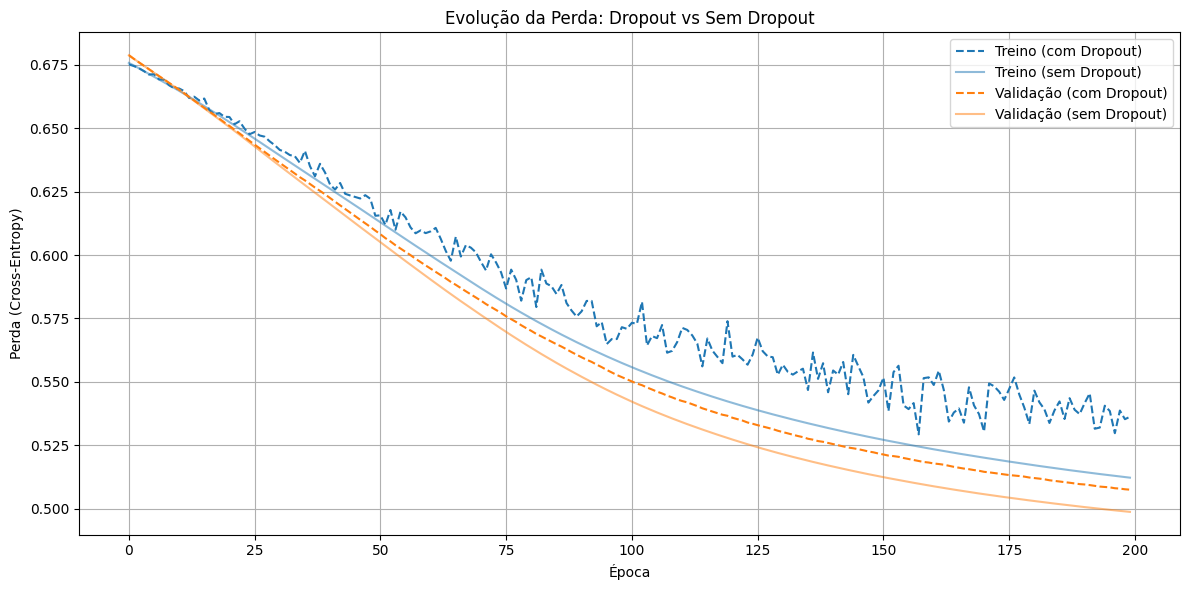

In [50]:
# 📊 Comparação visual da perda ao longo das épocas
import matplotlib.pyplot as plt

epocas_range = range(epocas)

plt.figure(figsize=(12, 6))

# Curvas de treino
plt.plot(epocas_range, historico['com_dropout']['treino'], label='Treino (com Dropout)', linestyle='--', color='tab:blue')
plt.plot(epocas_range, historico['sem_dropout']['treino'], label='Treino (sem Dropout)', linestyle='-', color='tab:blue', alpha=0.5)

# Curvas de validação
plt.plot(epocas_range, historico['com_dropout']['val'], label='Validação (com Dropout)', linestyle='--', color='tab:orange')
plt.plot(epocas_range, historico['sem_dropout']['val'], label='Validação (sem Dropout)', linestyle='-', color='tab:orange', alpha=0.5)

plt.xlabel('Época')
plt.ylabel('Perda (Cross-Entropy)')
plt.title('Evolução da Perda: Dropout vs Sem Dropout')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
def avaliar(modelo, entradas, saidas_reais):
    saidas_preditas = []
    for amostra in entradas:
        entrada_valores = [Valor(x) for x in amostra]
        saidas_preditas.append(modelo(entrada_valores, training=False))
    return cross_entropy(saidas_reais.flatten(), saidas_preditas)

perda_teste_dropout = avaliar(modelo_com_dropout, entradas_teste, saidas_teste)
perda_teste_sem_dropout = avaliar(modelo_sem_dropout, entradas_teste, saidas_teste)

print(f"\n🎯 Avaliação final no conjunto de teste:")
print(f"Com dropout: perda = {perda_teste_dropout.data:.4f}")
print(f"Sem dropout: perda = {perda_teste_sem_dropout.data:.4f}")



🎯 Avaliação final no conjunto de teste:
Com dropout: perda = 0.5470
Sem dropout: perda = 0.5412


### Conclusões

A aplicação do dropout introduziu uma característica notável no comportamento da rede, evidenciada pelo ruído nas curvas de perda durante o treinamento. Essa oscilação é esperada, pois o dropout desativa aleatoriamente neurônios a cada época, o que dificulta a memorização dos dados e torna o processo de aprendizagem mais instável no curto prazo. No entanto, mesmo com essa flutuação, a perda de validação permaneceu próxima daquela observada na rede sem dropout — o que é um excelente sinal.

Isso indica que o dropout, apesar de tornar o treinamento menos suave, contribui para uma maior robustez e generalização do modelo. Em outras palavras, ele ajuda a evitar o sobreajuste (overfitting) ao forçar a rede a não depender de neurônios específicos, promovendo um aprendizado mais distribuído e resiliente. Mesmo com uma perda final ligeiramente maior, a rede com dropout tende a ser mais confiável quando exposta a dados nunca vistos.


#### Referências 

CASSAR, Daniel Roberto. ATP-303 NN 4.2 – Notebook MLP. Material did´atico
disponibilizado na ILUM – Escola de Ciˆ